## Dictionary Leanring for TEM signal
Input: Clean TEM signal

Output: Dictionary atoms, sparse matrix 

Prepare simulation TEM signal for Dictionray Leanring

## Dictionary Leanring for TEM signal matrix decomposition
Step1: View clean TEM data

Training Data Shape: (2000, 1600)


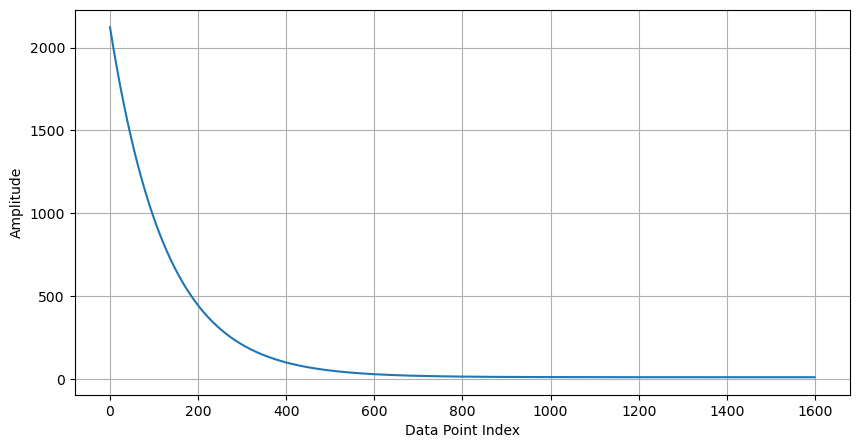

In [47]:
import torch
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

"""Lodaing TEM signal"""
clean_data = scipy.io.loadmat("TEM_Signal/clean_signal.mat")['clean_signal']
assert clean_data is not None, "Data loading failed."
print(f"Training Data Shape: {clean_data.shape}")

"""View a signal sample"""
sample_index:int = 666
sample_signal = clean_data[666]
plt.figure(figsize=(10, 5))
plt.plot(sample_signal)
plt.xlabel("Data Point Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


## Utils
1.Init environment for Dictionary Leanring and init atoms, sparse matirx.

2.Training.

3.view signal.

4.view Dic & Sparse matrix.

5.MSE & Sparsity compute.

In [66]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR

def setup_dl_env(
                 clean_signal, leanring_base_rate:float = 0.1,
                 K:int = None, device_type:str = 'cuda', 
                 use_cosine_scheduler:bool = False, patience:int=100
                 ):
    """
    clean_signal: Input TEM signal data (num_sample, num_sample_point) e.g., (2000, 1600).
    K: Number of dictionary atoms setting, default: 64.
    device_type: Device choose (cuda or cpu), default: cuda.
    use_cosine_scheduler: Cosine_scheduler setting, default: False.
    patience: Early termination strategy, default: 100.
    """
    assert clean_signal is not None, "Error: clean_signal must be provided as a 2D numpy array."
    
    #GPU/CPU setting
    device = torch.device(device_type if torch.cuda.is_available() else "cpu")
    """optional setting"""
    # if device_type == 'cuda' and torch.cuda.is_available():
    #     torch.autocast(device_type='cuda', dtype=torch.float32).__enter__()
    #     if torch.cuda.get_device_properties(0).major >= 8:
    #         torch.backends.cuda.matmul.allow_tf32 = True
    #         torch.backends.cudnn.allow_tf32 = True 
    
    #Standardize 
    mean = np.mean(clean_signal, axis=0)  # 原始数据的均值
    std = np.std(clean_signal, axis=0) 
    clean_signal = (clean_signal - mean) / (std)
    clean_signal_tensor = torch.tensor(clean_signal, dtype=torch.float32).to(device)
    clean_signal_tensor = clean_signal_tensor.T #(1600, 2000)
    
    """Init Dic atoms using PCA"""
    M,N = clean_signal_tensor.shape
    pca = PCA(n_components=K)
    Dic_atom = pca.fit(clean_signal).components_.T
    Dic_atom = torch.tensor(Dic_atom, dtype=torch.float32, device=device) #Shape: (num_sample_point, K)
    
    """Init sparse matrix A"""
    A = torch.zeros(K, N, requires_grad=True, device=device) #Shape: (K, num_sample)

    #Optimizer & scheduler setting
    optimizer_A = torch.optim.Adam([A], lr=leanring_base_rate)
    if use_cosine_scheduler:
        scheduler = CosineAnnealingLR(optimizer_A, T_max=10000, eta_min=1e-6)
    else:
        scheduler = ReduceLROnPlateau(optimizer_A, mode='min', factor=0.9, patience=patience, verbose=True, min_lr=1e-5)
    
    return clean_signal_tensor, Dic_atom, A, optimizer_A, scheduler, mean, std

def dic_learn_trian(C_train_tensor, D, A, optimizer_A, scheduler, K, 
                              l1_weight: float = None, l1_decay: float = None, 
                              loss_threshold: float = None, num_epochs: int = 2000, 
                              ):
    """
    l1_weight: L1 regularization weight, default: 0.1.
    l1_decay: L1 decay rate, default: 0.999.
    loss_threshold: Early termination by loss, default: 
    epochs: Number of training epoch, default: 2000.
    """
    from tqdm import tqdm
    with tqdm(total=num_epochs, desc="Training Progress") as pbar:
        for epoch in range(num_epochs):
            current_l1_weight = max(l1_weight * (l1_decay ** epoch), 0.01) if l1_weight is not None and l1_decay is not None else l1_weight

            """1.Update sparse code A"""
            C_hat = torch.matmul(D, A)
            reconstruction_loss = torch.norm(C_train_tensor - C_hat, p='fro') ** 2
            sparsity_loss = current_l1_weight * torch.norm(A, p=1)
            loss = reconstruction_loss + sparsity_loss
            optimizer_A.zero_grad()
            loss.backward()
            optimizer_A.step()
            scheduler.step(loss)

            """2.Update dictionary atoms"""
            with torch.no_grad():
                for k in range(K):
                    indices = A[k, :] != 0
                    if torch.sum(indices) == 0:
                        continue
                    C_residual = C_train_tensor - torch.matmul(D, A) + torch.outer(D[:, k], A[k, :])
                    C_residual = C_residual.T  # Transpose back to original shape (N, M)
                    D[:, k] = torch.matmul(C_residual.T[:, indices], A[k, indices]) / torch.norm(
                        torch.matmul(C_residual.T[:, indices], A[k, indices])
                    )

            pbar.update(1)
            pbar.set_postfix({
                #"Loss": f"{loss.item():.6f}",
                "Recon_loss": f"{reconstruction_loss.item():.6f}",
                "Sparsity": f"{sparsity_loss.item():.6f}"
            })
            
            #print progress every 100 epochs
            if (epoch + 1) % 400 == 0:
                current_lr = optimizer_A.param_groups[0]['lr']
                print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {current_lr:.6e}, Current_l1_weight: {current_l1_weight:.6e}")

            # Early stopping condition
            if loss.item() < loss_threshold:
                print(f"Early stopping at epoch {epoch + 1}: Loss {loss.item():.6f} < Threshold {loss_threshold}")
                break

    D_final = D.detach().cpu() 
    A_final = A.detach().cpu()
    print(f"Dictionary shape: {D_final.shape}, Sparse Code shape: {A_final.shape}")
    return D_final, A_final

def save_as_mat(save_path, dictionary, sparse_matirx, mean, std):

    dictionary_path = save_path[0]
    sparse_code_path = save_path[1]
    Recon_signals_path = save_path[2]

    dictionary = dictionary.numpy() 
    sparse_matirx = sparse_matirx.numpy() 
    sparsity_threshold = 5e-3
    sparse_matirx = np.where(np.abs(sparse_matirx) < sparsity_threshold, 0, sparse_matirx) #Enhance sparsity

    Recon_signals = np.matmul(dictionary, sparse_matirx) * std.reshape(-1, 1) + mean.reshape(-1, 1)
    Recon_signals = Recon_signals.T
    
    scipy.io.savemat(dictionary_path, {'dictionary': dictionary})
    scipy.io.savemat(sparse_code_path, {'sparse_code': sparse_matirx})
    scipy.io.savemat(Recon_signals_path, {'recon_signal': Recon_signals})
    print(f"Dictionary saved to: {dictionary_path}")
    print(f"Sparse code saved to: {sparse_code_path}")
    print(f"Recon signals saved to: {Recon_signals_path}")

def view_signal(inp_path, inp_key, sample_index):
    
    inp_data = scipy.io.loadmat(inp_path)[inp_key]
    assert inp_data is not None, "Data loading failed."
    sample_signal = inp_data[sample_index,:]  

    plt.figure(figsize=(10, 5))
    plt.plot(sample_signal)
    plt.xlabel("Data Point Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

def view_D_A(inp_path, sample_index):

    Dic_data = scipy.io.loadmat(inp_path[0])['dictionary']
    assert Dic_data is not None, "Dic_data loading failed."

    A_data = scipy.io.loadmat(inp_path[1])['sparse_code']
    assert A_data is not None, "A_data loading failed."

    #view dictionary atoms
    plt.figure(figsize=(10, 5))
    plt.plot(Dic_data)
    plt.title("Dictionary")
    plt.xlabel("Data Point Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    #view sparse metrix
    plt.figure(figsize=(10, 5))
    plt.plot(A_data[:,sample_index].reshape(-1,1))
    plt.title(f"Sparse Code")
    plt.xlabel("Data Point Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    #view pre-64 dictionary atoms
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    fig.suptitle("Dictionary Atoms Visualization", fontsize=16)
    for i in range(8):  
        for j in range(8): 
            atom_index = i * 8 + j
            ax = axes[i, j]
            ax.plot(Dic_data[:, atom_index])
            ax.set_title(f"Atom {atom_index+1}")
            ax.axis('off')
            ax.grid(False)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    #view 64x64 sparse matirx
    A_64x64 = A_data[:64, :64]
    plt.figure(figsize=(8, 6))
    plt.imshow(A_64x64, cmap='seismic', aspect='auto', vmin=-np.max(np.abs(A_64x64)), vmax=np.max(np.abs(A_64x64)))
    plt.colorbar(label="Value")
    plt.title("64x64 Subsection of Sparse Matrix (Positive/Negative Values Highlighted)")
    plt.xlabel("Column Index")
    plt.ylabel("Row Index")
    plt.show()


def MSE_Sparsity_compute(recon_path, ori_path, A_path, sparsity_threshold):
    
    Recon_data = scipy.io.loadmat(recon_path[0])[recon_path[1]]
    assert Recon_data is not None, "Recon_data loading failed."

    Ori_data = scipy.io.loadmat(ori_path[0])[ori_path[1]]
    assert Ori_data is not None, "Ori_data loading failed."

    A_data = scipy.io.loadmat(A_path)['sparse_code']
    assert A_data is not None, "A_data loading failed."

    #compute MSE
    Loss2 = np.mean(abs(Recon_data-Ori_data))
    print(f"MSE between recon data & orignal clean data: {Loss2}")

    #compute Sparisity
    total_elements = A_data.size
    sparse_elements = np.sum(np.abs(A_data) <= sparsity_threshold)
    sparsity = (sparse_elements / total_elements) * 100 
    print(f"Sparsity of sparse matrix:{sparsity}")



## Training: Iterative optimization of dictionaries and sparse matrices

In [ ]:
"""Setting your own paramter combination."""
"""Auto parameter search policy is recommended."""
Leanring_base_rate = 0.1
K = 64
L1_weight = 0.1
L1_decay = 0.999
Loss_threshold = 0.2
Epochs = 2000
Patience = 100

Clean_tensor, D, A, optimizer_A, scheduler, mean, std = setup_dl_env(clean_data, leanring_base_rate=Leanring_base_rate, K=K, 
                                                          device_type='cuda', use_cosine_scheduler=False, patience=Patience)

D_final, A_final = dic_learn_trian(Clean_tensor, D, A, optimizer_A, scheduler, K=K, l1_weight=L1_weight, 
                                   l1_decay=L1_decay, loss_threshold=Loss_threshold, num_epochs=Epochs)


Training Progress:  20%|██        | 403/2000 [00:22<01:31, 17.50it/s, Recon_loss=14.907184, Sparsity=5053.251953]    

Epoch 400/2000, Learning Rate: 1.000000e-01, Current_l1_weight: 6.708568e-02


Training Progress:  40%|████      | 803/2000 [00:44<01:05, 18.33it/s, Recon_loss=4.936800, Sparsity=3174.753906] 

Epoch 800/2000, Learning Rate: 1.000000e-01, Current_l1_weight: 4.495987e-02


Training Progress:  60%|██████    | 1204/2000 [01:06<00:40, 19.63it/s, Recon_loss=2.909266, Sparsity=2074.068604]

Epoch 1200/2000, Learning Rate: 1.000000e-01, Current_l1_weight: 3.013147e-02


Training Progress:  80%|████████  | 1604/2000 [01:28<00:22, 17.75it/s, Recon_loss=2.904081, Sparsity=1371.864014]

Epoch 1600/2000, Learning Rate: 1.000000e-01, Current_l1_weight: 2.019369e-02


Training Progress: 100%|██████████| 2000/2000 [01:50<00:00, 18.08it/s, Recon_loss=3.618166, Sparsity=915.653015] 

Epoch 2000/2000, Learning Rate: 1.000000e-01, Current_l1_weight: 1.353353e-02
Dictionary shape: torch.Size([1600, 64]), Sparse Code shape: torch.Size([64, 2000])


## SAVE results

Dictionary saved to: dictionary.mat
Sparse code saved to: sparse_code.mat
Recon signals saved to: Recon_signal.mat
MSE between recon data & orignal clean data: 0.13631205937197632
Sparsity of sparse matrix:53.500781249999996


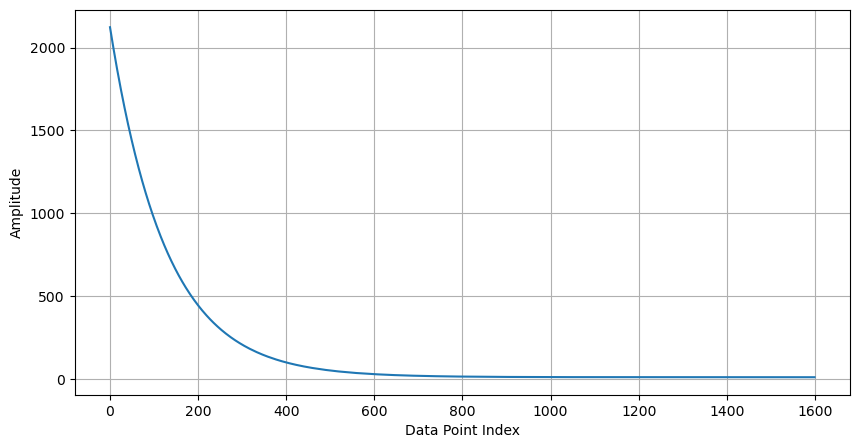

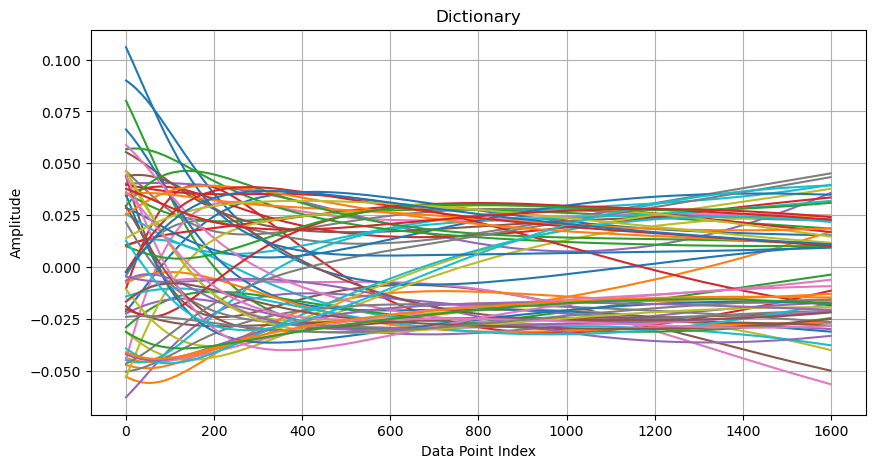

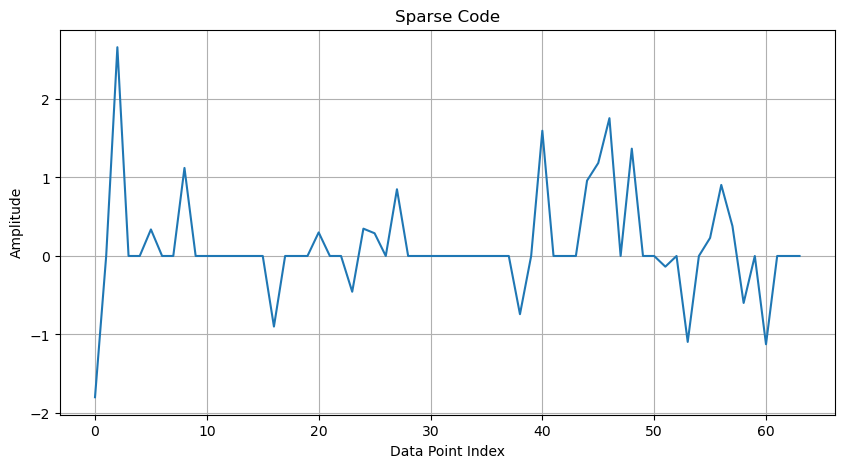

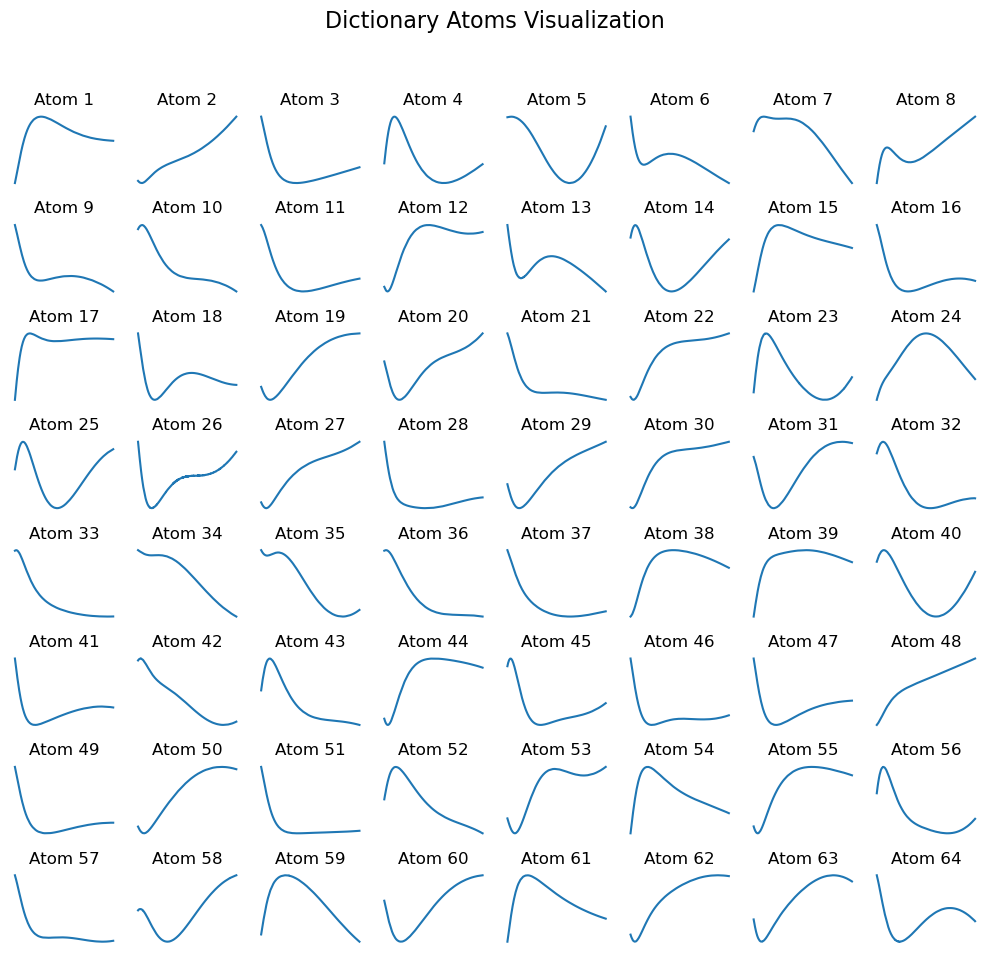

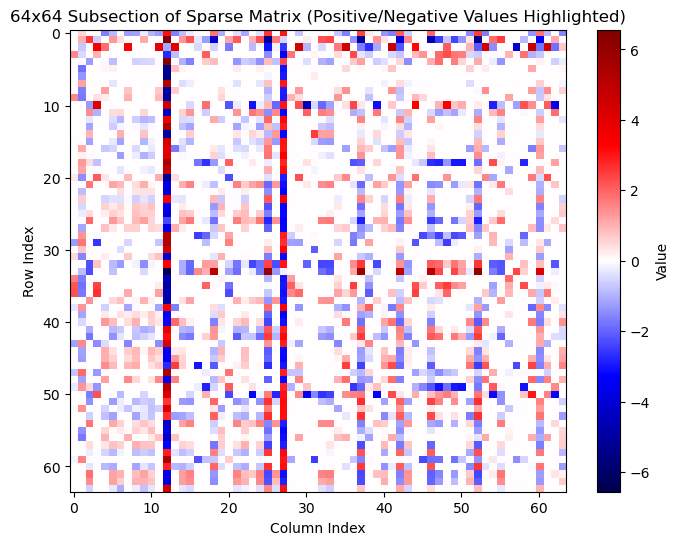

In [67]:
SAVE_PATH = ['dictionary.mat','sparse_code.mat','Recon_signal.mat']
Recon_PATH = ['Recon_signal.mat','recon_signal']
Clean_PATH = ['TEM_Signal/clean_signal.mat','clean_signal']
save_as_mat(SAVE_PATH, D_final, A_final, mean, std)
MSE_Sparsity_compute(Recon_PATH, Clean_PATH, SAVE_PATH[1], sparsity_threshold=5e-3) #sparsity_threshold was set in save_as_mat function.
view_signal(Recon_PATH[0], Recon_PATH[1], 666)
view_D_A(SAVE_PATH,sample_index=666)